In [1]:
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# Importing the images as np.array

In [2]:

X = []
y = []
classes = ['Fu', 'wth', 'i_have_no_idea', 'moutza']
base_path = '/home/xrusa/Documents/euclidean-eukalyptus/work_in_progress/week_9/imageclassifier/src/data/gestures/'

for i, target in enumerate(classes):
      files = base_path+target+'/'
      for file in os.listdir(files):
         # load the image
         img = image.load_img(files+file)
         # convert it to an array
         img_array = image.img_to_array(img, dtype='uint8')
         # append the array to X
         X.append(img_array)
         # append the target to y
         y.append(target)


X = np.array(X)
y = np.array(y)
y_dict = {'Fu':0, 'wth':1, 'i_have_no_idea':2, 'moutza':3}
y = np.vectorize(y_dict.get)(y)

# shuffle the data
shuffler = np.random.permutation(len(X))
X = X[shuffler]
y = y[shuffler]



In [3]:
X.shape

(588, 224, 224, 3)

In [4]:
y.shape 

(588,)

# Create the model

## Split the data into train and test

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((441, 224, 224, 3), (441,), (147, 224, 224, 3), (147,))

## One hot encode the labels

In [7]:
y_test_true = y_test.copy()

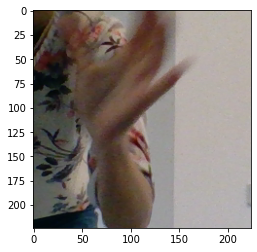

In [8]:

plt.imshow(X_train[0],cmap='gray')

In [9]:
y_train[0]

3

In [10]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train.shape, y_test.shape

((441, 4), (147, 4))

In [11]:
y_train.shape, y_test.shape, X_train.shape

((441, 4), (147, 4), (441, 224, 224, 3))

# Define the model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import models, layers

In [23]:
from tensorflow.keras import backend as K
K.clear_session()
model = Sequential([
    Conv2D(filters = 16, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu' ,input_shape = (224,224,3)),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'same'),
    BatchNormalization(), # optional
    Conv2D(filters = 40, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'same'),
    BatchNormalization(), # optional
    Conv2D(filters = 8, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu'),
    MaxPooling2D(pool_size = (2,2),strides=(2,2),padding = 'same'),
    BatchNormalization(), # optional
    
    Flatten(),
    
    Dense(80,activation='relu'),
    Dropout(0.2),
    Dense(40,activation='relu'),
    Dense(4,activation= 'softmax')

    
])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 40)      5800      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 40)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 40)        160       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 8)         2

## Compile the model

In [25]:
from tensorflow.keras.optimizers import Adam

In [26]:

model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

## Hyperparameter tuning


## Is the model overfitting?

In [ ]:
def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

In [ ]:
# Train the model for 60 epochs, using X_test and y_test as validation data
history = model.fit(X_train, y_train, epochs=60, validation_data=(X_test, y_test), verbose=0)
 
# Extract from the history object loss and val_loss to plot the learning curve
plot_loss(history.history['loss'], history.history['val_loss'])

## Do I need more data?

In [27]:
initial_weights = model.get_weights()
train_accs = []
test_accs = []
training_sizes = np.array([ 125,  502,  879, 1255])
early_stop = EarlyStopping(monitor='loss', patience=3)

In [ ]:
for size in training_sizes:
  	# Get a fraction of training data (we only care about the training data)
    X_train_frac, y_train_frac = X_train[:size], y_train[:size]

    # Reset the model to the initial weights and train it on the new training data fraction
    model.set_weights(initial_weights)
    model.fit(X_train_frac, y_train_frac, epochs = 50, callbacks = [early_stop])

    # Evaluate and store both: the training data fraction and the complete test set results
    train_accs.append(model.evaluate(X_train_frac, y_train_frac)[1])
    test_accs.append(model.evaluate(X_test, y_test)[1])
    


In [ ]:
# Plot train vs test accuracies
def plot_results(train_accuracy,test_accuracy):
  plt.figure()
  plt.plot(train_accuracy)
  plt.plot(test_accuracy)
  plt.title('Accuracy vs number of training samples')
  plt.ylabel('Accuracy')
  plt.xlabel('# number of training samples')
  plt.legend(['Training accuracy', 'Test accuracy'], loc='upper right')
  plt.show()

In [ ]:
plot_results(train_accs, test_accs)

In [14]:
# Creates a model given an activation and learning rate
def create_model(learning_rate, activation):
  
    # Create an Adam optimizer with the given learning rate
    opt = Adam(lr = learning_rate)

    # Create your binary classification model  
    model = Sequential()
    model.add(Dense(128, input_shape = (224,224,3), activation = activation))
    model.add(Dense(256, activation = activation))
    model.add(Dense(1, activation = 'sigmoid'))

    # Compile your model with your optimizer, loss, and metrics
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [17]:
# Import KerasClassifier from keras scikit learn wrappers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, KFold
from tensorflow.keras import backend as K
K.clear_session()

# Create a KerasClassifier
model = KerasClassifier(build_fn = create_model)

# Define the parameters to try out
params = {'activation': ['relu', 'tanh'], 'batch_size': [32, 128, 256], 
          'epochs': [50, 100, 200], 'learning_rate': [0.1, 0.01, 0.001]}

# Create a randomize search cv object passing in the parameters to try
random_search = RandomizedSearchCV(model, param_distributions = params, cv = KFold(3))
random_search.fit(X_train, y_train)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", random_search.best_estimator_)
print("\n The best score across ALL searched params:\n", random_search.best_score_)
print("\n The best parameters across ALL searched params:\n", random_search.best_params_)

/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/200


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/200


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/200


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/200


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/200


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/200


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
Epoch 1/50


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/50


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100


/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/wrappers/scikit_learn.py", line 220, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "/home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/ke

Epoch 1/200


ValueError: in user code:

    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:862 train_function  *
        return step_function(self, iterator)
    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:852 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:845 run_step  **
        outputs = model.train_step(data)
    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:803 train_step
        loss = self.compiled_loss(
    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:155 __call__
        losses = call_fn(y_true, y_pred)
    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:259 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:1823 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:5036 binary_crossentropy
        return nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /home/xrusa/anaconda3/envs/tf/lib/python3.9/site-packages/tensorflow/python/ops/nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 224, 224, 1) vs (None, 4))


In [ ]:
# training with cross validation
# Import KerasClassifier from keras wrappers
from keras.wrappers.scikit_learn import KerasClassifier

# Create a KerasClassifier
model = KerasClassifier(build_fn = create_model(learning_rate = 0.001, activation = 'relu'), epochs = 50, 
             batch_size = 128, verbose = 0)

# Calculate the accuracy score for each fold
kfolds = cross_val_score(model, X, y, cv = 3)

# Print the mean accuracy
print('The mean accuracy was:', kfolds.mean())

# Print the accuracy standard deviation
print('With a standard deviation of:', kfolds.std())

## Fit the model

In [28]:
history = model.fit(X_train,y_train ,batch_size=32, epochs=30, callbacks= [early_stop], validation_split=0.2)

Epoch 1/30
11/11 [==============================] - 9s 684ms/step - loss: 0.9219 - accuracy: 0.6506 - val_loss: 12.5874 - val_accuracy: 0.3483
Epoch 2/30
11/11 [==============================] - 7s 617ms/step - loss: 0.2214 - accuracy: 0.9318 - val_loss: 7.5044 - val_accuracy: 0.3596
Epoch 3/30
11/11 [==============================] - 7s 679ms/step - loss: 0.0811 - accuracy: 0.9801 - val_loss: 6.0860 - val_accuracy: 0.3820
Epoch 4/30
11/11 [==============================] - 7s 649ms/step - loss: 0.0625 - accuracy: 0.9773 - val_loss: 1.3990 - val_accuracy: 0.6404
Epoch 5/30
11/11 [==============================] - 7s 623ms/step - loss: 0.0435 - accuracy: 0.9830 - val_loss: 1.4250 - val_accuracy: 0.5730
Epoch 6/30
11/11 [==============================] - 7s 658ms/step - loss: 0.0421 - accuracy: 0.9858 - val_loss: 1.2472 - val_accuracy: 0.6067
Epoch 7/30
11/11 [==============================] - 7s 641ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 1.4691 - val_accuracy: 0.6404
Epoch

In [29]:
model.save('/home/xrusa/Documents/euclidean-eukalyptus/work_in_progress/week_9/project/model.h5')


In [30]:
history.history

{'loss': [0.9219226837158203,
  0.22137902677059174,
  0.08107712119817734,
  0.06248343363404274,
  0.04350477457046509,
  0.042095035314559937,
  0.012820195406675339,
  0.010411476716399193,
  0.005265586078166962,
  0.004790479317307472,
  0.0020337477326393127,
  0.013460376299917698,
  0.0024659072514623404,
  0.002666492946445942],
 'accuracy': [0.6505681872367859,
  0.9318181872367859,
  0.9801136255264282,
  0.9772727489471436,
  0.9829545617103577,
  0.9857954382896423,
  1.0,
  0.9971590638160706,
  1.0,
  1.0,
  1.0,
  0.9943181872367859,
  1.0,
  1.0],
 'val_loss': [12.587367057800293,
  7.504410266876221,
  6.085977077484131,
  1.3989880084991455,
  1.4250212907791138,
  1.2471613883972168,
  1.4691275358200073,
  1.777129054069519,
  1.2744760513305664,
  0.9533535242080688,
  0.7697526812553406,
  0.8174704313278198,
  0.5870085954666138,
  0.4676789343357086],
 'val_accuracy': [0.3483146131038666,
  0.3595505654811859,
  0.3820224702358246,
  0.6404494643211365,
  0.57

Text(0, 0.5, 'accuracy')

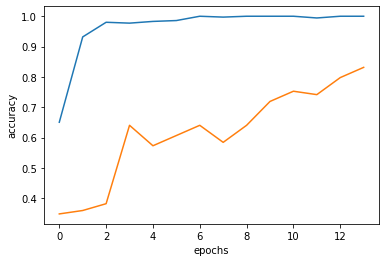

In [31]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

Text(0, 0.5, 'loss')

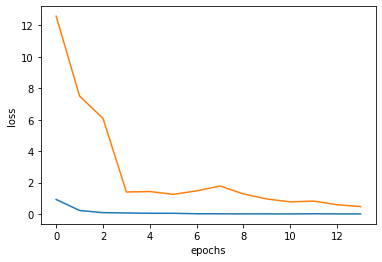

In [32]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')

In [ ]:
pred = model.predict(X_test)

In [ ]:
plt.imshow(X_test[-1])

In [ ]:
y_test[-1]

In [ ]:

y_test_true[-1]

In [ ]:
y_dict

## Evaluate the data

In [33]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.8560576438903809 / Test accuracy: 0.8571428656578064


# Test random incoming pictures

## Test random gestures from my camera

In [ ]:
X_random = []

for i, target in enumerate(classes):
      file_path = '/home/xrusa/Documents/euclidean-eukalyptus/work_in_progress/week_9/imageclassifier/src/data/random_gestures/'
      for file in os.listdir(file_path):
         # load the image
         img = image.load_img(file_path+file)
         # convert it to an array
         img_array = image.img_to_array(img, dtype='uint8')
         # append the array to X
         X_random.append(img_array)
         
        

X_random = np.array(X_random)


In [ ]:
preds_random = model.predict(X_random)


In [ ]:
def get_pred(list_name):

    max_value = []
    max_indexes = []
    results = []

    for pred in list_name:
        a = np.amax(pred)
        max_value.append(a)
        pred = list(pred)
        max_index = pred.index(a)
        max_indexes.append(max_index)


    for index in max_indexes:
        if index == 0:
            results.append('F@ck you in Italian')
        elif index == 1:
            results.append('what the hell are you talking about?')
        elif index == 2:
            results.append('i honestly have no idea')
        else:
            results.append('Take it to your face aka moutza')
    return results


labels = get_pred(preds_random)


In [ ]:
plt.imshow(X_random[6])

In [ ]:
labels[6]


# Extra code

## In case pictures are not preprocessed to (224,224)

In [ ]:
# For pictures that are not taken from the camera

def TestImgPreprocessing(path):
    '''
    Resizes all images in a given file path to (224,224) and MinMax scales 
    Return array of images
    Adapted from https://stackoverflow.com/questions/21517879/
    python-pil-resize-all-images-in-a-folder
    '''
    from PIL import Image
    import os
    dirs = sorted(os.listdir(path))
    images = []
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((224,224), Image.ANTIALIAS)
            imResize = np.asarray(imResize)/255
            images.append(imResize)
    return np.asarray(images)

test_imgs = TestImgPreprocessing('/home/xrusa/Documents/euclidean-eukalyptus/work_in_progress/week_9/imageclassifier/src/data/random_gestures_sent/')